In [1]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Scalar_Dissipation_Function
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams.update({'legend.title_fontsize':5.5})
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

In [2]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N = 100000
dtau = (tau_end - tau_ini) / N # DT is a negative quantity as expected since tau is decreasing over time
taus = np.linspace(tau_ini, tau_end, N)


#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation=60 #Number of e-folds of after CMB horizon crossing
Ne_pert= 10 # Number of e-folds before CMB horizon crossing
Nruns=1024 #How many runs we average over to compute the perturbations
MPs_bool='wo' #without metric perturbations
epsH_etaH_bool='wo' #negligible epsH and etaH


cm_cases=[[3,0],[1,0],[-1,0]]

In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='quartic'

lv = 10**(-14)  # value of lambda

Model = InflatonModel('monomial', [lv, 4], g, a1, Mpl)


################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

ICs_Q0_ph0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'.txt')
Q0s=ICs_Q0_ph0[:,0]
ph0s=ICs_Q0_ph0[:,1]

########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic=np.zeros(len(Q0s))
for i in trange(len(Q0s)):
    Bg=Background(Model,ph0s[i],Q0s[i])
    R2_analytic[i]=Bg.analytic_power_spectrum(int(Neinflation+Ne_pert), int(2*N), taus, Neinflation)
    del Bg


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.61it/s]


In [4]:
######################################################################
# Load solutions to the perturbations equations saved in a .txt file #
######################################################################

R2m_list, R2std_list=[],[]
for i in trange(len(cm_cases)):
    cval=cm_cases[i][0]
    mval=cm_cases[i][1]
    _,R2m,R2std=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c'+str(cval)+'m'+str(mval)+'_n'+str(int(N))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'.txt')
    R2m_list.append(R2m)
    R2std_list.append(R2std)
    del R2m, R2std,cval,mval
R2m_list=np.array(R2m_list) #Array containing the mean value of the scalar power spectrum <\mathcal{R}^2>
R2std_list=np.array(R2std_list) #Array containing the standard deivation of the scalar power spectrum <\mathcal{R}^2>

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.71it/s]


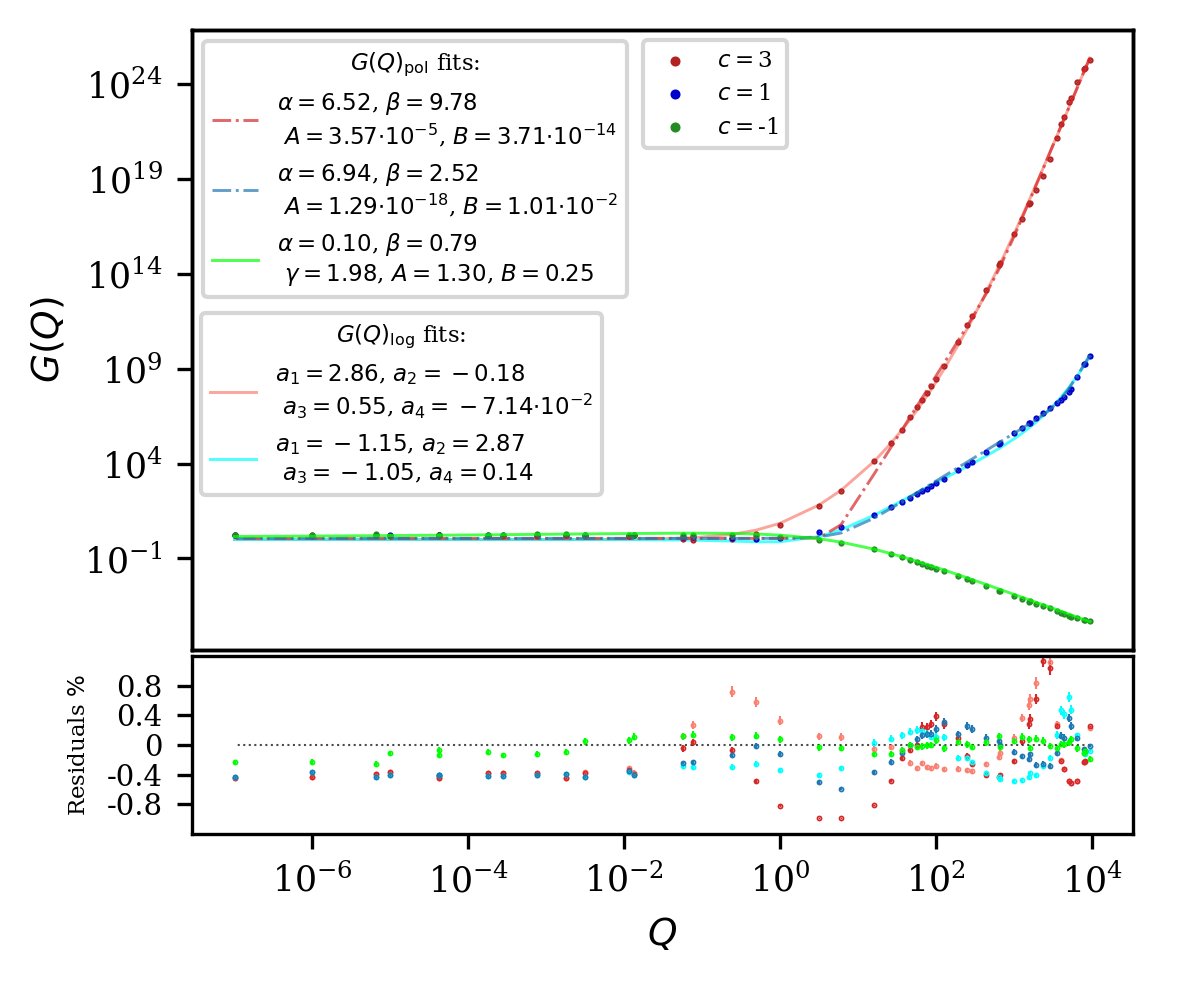

In [6]:
##########################################################################
# Function to compute residuals of the scalar dissipation function fits: #
##########################################################################

def residual_calculator(sig1,err1,sig2,err2):
    res_sig=(sig1-sig2)/sig1
    chi2=np.sum((sig1-sig2)**2/err1**2)
    res_err=np.sqrt((sig2/sig1**2*err1)**2+ (err2/sig1)**2)
    return res_sig, res_err,chi2

#############################################
# Function that formats legend in the plot: #
#############################################

def format_fit_pars(pars, mode='log'):
    global formatted_pars
    if mode=='log':
        formatted_pars=[r'$a_1=',r'$a_2=',r'$a_3=',r'$a_4=']
    if mode=='pol':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$A=',r'$B=']
    if mode=='negative_c':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$\gamma=',r'$A=',r'$B=']
    for i in range(len(pars)):
        pv=pars[i]
        exp = math.floor(math.log10(abs(pv))) # automatically detect the value of c
        if (exp>1) or (exp<=-2):
            formatted_pv = "{:.2f}⋅10^{{{}}}".format(pv / 10**exp, exp)
        else:
            formatted_pv = "{:.2f}".format(pv)
        #Add formatted_pv to the ith element of formatted_pars, before the last $ sign:
        formatted_pars[i]=formatted_pars[i]+formatted_pv+'$'
    #Return as a single string of two columns with commas between the elements:
    return ', '.join(formatted_pars[:len(pars)//2])+'\n '+', '.join(formatted_pars[len(pars)//2:])


###################################################
#  Make Figure where I plot the data and the fit: #
###################################################

fig1=plt.figure(figsize=(4.5,3.8),dpi=300)
gs1 = GridSpec(24,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:18,1:-1])
ax2 = fig1.add_subplot(gs1[18:-1,1:-1])
ax12 = ax1.twinx()
ax13 = ax1.twinx()

##############################
# Useful for general legend: #
##############################
models_cols_data=['firebrick','mediumblue','forestgreen']
models_cols_fits=['salmon','cyan','lime']
models_cols_fits_p=['tab:red','tab:blue']
cols_fits=['k','tab:red']
marker_Ne=['^','s','.']
ax2.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("$G(Q)$",fontdict={'fontsize':9,'family':'serif'})

ax2.set_ylabel("Residuals $\%$",fontdict={'fontsize':5.5,'family':'serif'})
GQs_sig,GQs_err=[],[]
j=0
while j in range(len(cm_cases)):
    ax13.scatter(np.NaN,np.NaN,label='$c=$'+str(cm_cases[j][0]),marker='.',s=8, c=models_cols_data[j])

    # Define the scalar dissipation function from the solution to the perturbations equations:
    Gf=Scalar_Dissipation_Function(Model,Q0s,ph0s,R2m_list[j],R2std_list[j],Nruns,int(Neinflation+Ne_pert),int(2*N),taus,Neinflation,cm_cases[j][0],cm_cases[j][1])
    # Compute the best fit values for the fitting functions of G(Q)
    pars_log,_,GQ_sig,GQ_err=Gf.scalar_dissipation_function_fit(method='log',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)
    pars_pol,_=Gf.scalar_dissipation_function_fit(method='pol',output_data=False,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic[j])
    GQs_sig.append(GQ_sig)
    GQs_err.append(GQ_err)
    ax1.errorbar(Q0s,GQ_sig,yerr=GQ_err,c=models_cols_data[j],marker='.',ls='none',markersize=1,linewidth=0.5)    
    if cm_cases[j][0]==-1:
        ax12.plot(Q0s,Gf.GQ_fit_func_negative_c_pol(Q0s,*pars_log),c=models_cols_fits[j],label=format_fit_pars(pars_log,'negative_c'),linewidth=0.7,alpha=0.7)        
        rsig,rerr,chi2=residual_calculator(GQ_sig,GQ_err,Gf.GQ_fit_func_negative_c_pol(Q0s,*pars_log),np.zeros(len(Q0s)))
        ax2.errorbar(Q0s,-rsig,yerr=rerr,c=models_cols_fits[j],marker='.',ls='none',markersize=.8,linewidth=0.5) 
    else:
        ax1.plot(Q0s,Gf.GQ_fit_func_positive_c_log(Q0s,*pars_log),c=models_cols_fits[j],label=format_fit_pars(pars_log,'log'),linewidth=0.7,alpha=0.7)        
        rsig,rerr,chi2=residual_calculator(GQ_sig,GQ_err,Gf.GQ_fit_func_positive_c_log(Q0s,*pars_log),np.zeros(len(Q0s)))
        ax2.errorbar(Q0s,-rsig,yerr=rerr,c=models_cols_fits[j],marker='.',ls='none',markersize=.8,linewidth=0.5) 
        ax12.plot(Q0s,Gf.GQ_fit_func_positive_c_pol(Q0s,*pars_pol),c=models_cols_fits_p[j],label=format_fit_pars(pars_pol,'pol'),linewidth=0.7,alpha=0.7,ls='-.')        
        rsig_p,rerr_p,chi2_p=residual_calculator(GQ_sig,GQ_err,Gf.GQ_fit_func_positive_c_pol(Q0s,*pars_pol),np.zeros(len(Q0s)))
        ax2.errorbar(Q0s,-rsig_p,yerr=rerr_p,c=models_cols_fits_p[j],marker='.',ls='none',markersize=.8,linewidth=0.5) 
    j+=1
    del pars_pol, pars_log
ax2.plot(Q0s,np.zeros(len(Q0s)),ls=':',alpha=0.7,linewidth=0.5,c='k')
ax13.get_yaxis().set_visible(False)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax12.set_yscale('log')
ax12.set_xscale('log')
ax2.set_xscale('log')
ax2.set_ylim(-1.2,1.2)
ax2.set_yticks(ticks=[-0.8,-0.4,0,0.4,0.8])
ax2.set_yticklabels([-0.8,-0.4,0,0.4,0.8], fontsize=7)
ax1.set_xticks(ticks=[])
ax12.set_xticks(ticks=[])
ax12.set_yticks(ticks=[])
ax1.legend(loc=(0.01,.25),prop={'family':'serif','size':5.5},framealpha=0.8,title=r'$G(Q)_{\rm{log}}$ fits:')
ax12.legend(loc=2,prop={'family':'serif','size':5.5},framealpha=0.8,title=r'$G(Q)_{\rm{pol}}$ fits:')
ax13.legend(loc=(0.48,.81),prop={'family':'serif','size':5.5},framealpha=0.8)
plt.savefig("../figures/GQ_quartic_fits.png")
plt.show()
plt.close()